<a href="https://colab.research.google.com/github/qingxinxia/OpenPackChallenge2025/blob/main/1.Data%20Augmentation%20Algorithm%20with%20HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factory Work Activity Recognition Challenge

This notebook has been designed for the 7th Factory Work Activity Recognition Challenge competition with the aim of Activity Recognition using REAL Accelerometer from OpenPack dataset and GENERATED Accelerometer created by participants.

If you have any questions, please feel free to email qingxinxia@hkust-gz.edu.cn with the subject Factory Work Activity Recognition Challenge.

About this dataset and challenge -> https://abc-research.github.io/challenge2025/

This notebook was prepared by Qingxin Xia.

---

# 工場作業活動認識チャレンジ
このノートブックは、OpenPackデータセットからの実際の加速度計と参加者によって生成された加速度計を使用して活動認識を目的とした第7回工場作業活動認識チャレンジコンペティションのために設計されました。

ご質問がある場合は、件名を「工場作業活動認識チャレンジ」として、qingxinxia@hkust-gz.edu.cnまでお気軽にメールしてください。

このデータセットとチャレンジについて -> https://abc-research.github.io/challenge2025/

このノートブックはQingxin Xiaによって準備されました。

# 1. Preparation

---

# 1. 準備する

## 1.1 Mount Drive

This tutorial is made in Google Colab. So, first we need to connect the Google Drive to access the data. You can directly add folder path to access the data.


---

## 1.1 Mount Drive

このチュートリアルは Google Colab で作成されています。そのため、まず Google ドライブに接続してデータにアクセスする必要があります。データにアクセスするには、フォルダー パスを直接追加できます。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Load Necessary Libraries and Prepare Environment

---
## 1.2 必要なライブラリをロードして環境を準備する


In [30]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import math
from scipy.interpolate import CubicSpline  # for warping
from einops import rearrange, repeat
from torch.autograd import Variable
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

cpu


## 1.3 Fixed Part

Participants do NOT need to change this part. When we evaluate the code, selected_columns and new_columns will not change. However, the split and random seed will change.


---
## 1.3 修正部分

参加者はこの部分を変更する必要はありません。コードを評価すると、selected_columns と new_columns は変更されません。ただし、split と random seed は変更されます。



In [3]:
splits = [0.7, 0.1, 0.2]
print('Randomly Split the real dataset into train, validation and test sets: %s'%str(splits))

selected_columns = ['atr01/acc_x','atr01/acc_y','atr01/acc_z','atr02/acc_x','atr02/acc_y','atr02/acc_z','timestamp','operation']
print('Select acceleration data of both wrists: %s'%selected_columns)

new_columns = selected_columns[:6] + [selected_columns[-1]]
print('Data for train, validation, and test: %s'%new_columns)

def set_random_seed(seed):
    # Set seed for Python's random module
    random.seed(seed)

    # Set seed for NumPy
    np.random.seed(seed)

    # Set seed for PyTorch
    torch.manual_seed(seed)

    # If using CUDA, set seed for GPU as well
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set a fixed random seed
seed_value = 2025
set_random_seed(seed_value)

Randomly Split the real dataset into train, validation and test sets: [0.7, 0.1, 0.2]
Select acceleration data of both wrists: ['atr01/acc_x', 'atr01/acc_y', 'atr01/acc_z', 'atr02/acc_x', 'atr02/acc_y', 'atr02/acc_z', 'timestamp', 'operation']
Data for train, validation, and test: ['atr01/acc_x', 'atr01/acc_y', 'atr01/acc_z', 'atr02/acc_x', 'atr02/acc_y', 'atr02/acc_z', 'operation']


## 1.4 Create Folders

Firstly, a folder is created to save OpenPack dataset: '/data/real/'.

Participants can download OpenPack dataset by themselves. The data should be placed at: '/data/real/'.

Another folder '/data/virtual/' will be created to save generated data.
 *(Note that, the size of this 'virtual' folder is limited to TBD.)*

---
## 1.4 フォルダーの作成

まず、OpenPack データセットを保存するためのフォルダー「/data/real/」が作成されます。

参加者は OpenPack データセットを自分でダウンロードできます。データは「/data/real/」に配置する必要があります。

生成されたデータを保存するために、別のフォルダー「/data/virtual/」が作成されます。

*(この「仮想」フォルダーのサイズは未定に制限されていることに注意してください。)*


In [4]:
realpath = r'/data/real'
virtpath = r'/data/virtual'
rootdir = r'/content/drive/MyDrive/OpenPackChallenge25'  # replace with your project path
real_directory = rootdir + realpath
virt_directory = rootdir + virtpath

# Create the directory
os.makedirs(real_directory, exist_ok=True)
print(f"Directory '{realpath}' created successfully.")

# Create the directory
os.makedirs(virt_directory, exist_ok=True)
print(f"Directory '{virtpath}' created successfully.")


Directory '/data/real' created successfully.
Directory '/data/virtual' created successfully.


## 1.5 Download data from Zenodo

Participants can also use this code to download the OpenPack dataset.


---
## 1.5 Zenodo からデータをダウンロード

参加者はこのコードを使用して OpenPack データセットをダウンロードすることもできます。


In [ ]:
# Construct the URL to the Zenodo API
api_url = f"https://zenodo.org/records/11059235"

# Send a request to the Zenodo API
response = requests.get(api_url)
response.raise_for_status()  # Check for HTTP errors

# # Parse the JSON response
# data = response.json()

# Extract the file information
download_url = f"https://zenodo.org/records/11059235/files/imu-with-operation-action-labels.zip?download=1"

# Download the file
file_response = requests.get(download_url)
file_response.raise_for_status()  # Check for HTTP errors

# Save the file
file_path = os.path.join(real_directory, 'imu-with-operation-action-labels.zip')
with open(file_path, 'wb') as f:
    f.write(file_response.content)

print(f"Downloaded to {file_path}")


Downloaded to /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels.zip


## 1.6 Unzip OpenPack dataset

After placing the OpenPack dataset at the '/data/real/' folder, unzip the files and delete the zip files.

---
## 1.6 OpenPack データセットを解凍する

OpenPack データセットを '/data/real/' フォルダに配置した後、ファイルを解凍し、zip ファイルを削除します。


In [ ]:
# Iterate over all files in the directory
for filename in os.listdir(real_directory):
    # Construct full file path
    file_path = os.path.join(real_directory, filename)

    # Check if the file is a zip file
    if filename.endswith('.zip'):
        # Open the zip file
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents of the zip file into the directory
            zip_ref.extractall(file_path[:-4])
            print(f"Extracted: {filename}")

        # Delete the zip file
        os.remove(file_path)
        print(f"Deleted: {filename}")

print("All zip files have been processed.")

Extracted: imu-with-operation-action-labels.zip
Deleted: imu-with-operation-action-labels.zip
All zip files have been processed.


# 2. Use Real Data to Generate Virtual Data

Firstly, we randomly split the real data into a training set, validation set, and test set according to a specific ratio. Participants can then use the training set to generate virtual data. Finally, we train the network using both the training set and the virtual data, and we calculate the F1 score on the test set.

The following code provides an example of generating virtual data from the training set. Note that: (1) The model structure is fixed and unchanged. (2) The split ratio for the training and test sets, as well as the random seed, will differ from the current settings, which requires the virtual data generation algorithm to be robust against varying data. (3) Participants are free to design data generation algorithms and save them to a specified path: '/data/virtual/', but the size of the virtual data is limited to TBD.

---

# 2. 実データを使用して仮想データを生成する

まず、実データを特定の比率に従ってトレーニング セット、検証セット、テスト セットにランダムに分割します。参加者はトレーニング セットを使用して仮想データを生成できます。最後に、トレーニング セットと仮想データの両方を使用してネットワークをトレーニングし、テスト セットの F1 スコアを計算します。

次のコードは、トレーニング セットから仮想データを生成する例を示しています。次の点に注意してください。(1) モデル構造は固定されており、変更されません。(2) トレーニング セットとテスト セットの分割比率、およびランダム シードは現在の設定とは異なります。そのため、仮想データ生成アルゴリズムは変化するデータに対して堅牢である必要があります。(3) 参加者はデータ生成アルゴリズムを自由に設計し、指定されたパス「/data/virtual/」に保存できますが、仮想データのサイズは未定に制限されます。

## 2.1 Assign train users, validation users, and test users

In the OpenPack dataset, U0xxx corresponds to user IDs, and S0xxx corresponds to different experiment settings.

In this Challenge, we will only select training (real) and test data from S0100.

---
## 2.1 トレーニング ユーザー、検証ユーザー、テスト ユーザーを割り当てる

OpenPack データセットでは、U0xxx はユーザー ID に対応し、S0xxx はさまざまな実験設定に対応します。

このチャレンジでは、S0100 からトレーニング (実際の) データとテスト データのみを選択します。


## 2.2 Filter out un-used data

---

## 2.2 未使用のデータを除外する

In [6]:
user_paths = {}
for root, dirs, files in os.walk(real_directory):
    for file in files:
        if file.endswith('S0100.csv'):
            user_paths[file[:-10]] = os.path.join(root, file)
        else:
          os.remove(os.path.join(root, file))  # remove unused data
for u, d in user_paths.items():
    print('%s at: %s'% (u,d))

U0101 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U0101-S0100.csv
U0102 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U0102-S0100.csv
U0103 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U0103-S0100.csv
U0104 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U0104-S0100.csv
U0105 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U0105-S0100.csv
U0106 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U0106-S0100.csv
U0107 at: /content/drive/MyDrive/OpenPackChallenge25/data/real/imu-with-operation-action-labels/imu-with-operation-action-labels/U

## 2.3 Split users to train, validation, and test sets

---

## 2.3 ユーザーをトレーニング、検証、テストセットに分割する

In [7]:
userIDs = list(user_paths.keys())

# Shuffle the list to ensure randomness
random.shuffle(userIDs)

# Calculate the split indices
total_length = len(userIDs)
train_size = int(total_length * splits[0])  # 70% of 10
val_size = int(total_length * splits[1])  # 10% of 10
test_size = total_length - train_size - val_size  # 20% of 10

# Split the list according to the calculated sizes
train_users = np.sort(userIDs[:train_size])      # First 70%
val_users = np.sort(userIDs[train_size:train_size + val_size])  # Next 10%
test_users = np.sort(userIDs[train_size + val_size:])  # Last 20%

print('Training set: %s'%train_users)
print('Validation set: %s'%val_users)
print('Test set: %s'%test_users)


Training set: ['U0102' 'U0104' 'U0105' 'U0107' 'U0108' 'U0109' 'U0110' 'U0111' 'U0201'
 'U0202' 'U0203' 'U0204' 'U0208' 'U0209']
Validation set: ['U0101' 'U0210']
Test set: ['U0103' 'U0106' 'U0205' 'U0206' 'U0207']


## 2.4 Load data according to userIDs

Load data of every user as dataframe.
Use acceleration data of both wrists only;
Use operation label.

---
## 2.4 ユーザーID に従ってデータをロードします

すべてのユーザーのデータをデータフレームとしてロードします。
両手首の加速度データのみを使用します。
操作ラベルを使用します。


In [8]:
# selected_columns = ['atr01/acc_x','atr01/acc_y','atr01/acc_z','atr02/acc_x','atr02/acc_y','atr02/acc_z','timestamp','operation']
train_data_dict = {}
for u in train_users:
    # Load the CSV file with only the selected columns
    train_data_dict[u] = pd.read_csv(user_paths[u], usecols=selected_columns)

val_data_dict = {}
for u in val_users:
    # Load the CSV file with only the selected columns
    val_data_dict[u] = pd.read_csv(user_paths[u], usecols=selected_columns)

test_data_dict = {}
for u in test_users:
    # Load the CSV file with only the selected columns
    test_data_dict[u] = pd.read_csv(user_paths[u], usecols=selected_columns)

## 2.5 Show an example of data

---
## 2.5 データの例を示す


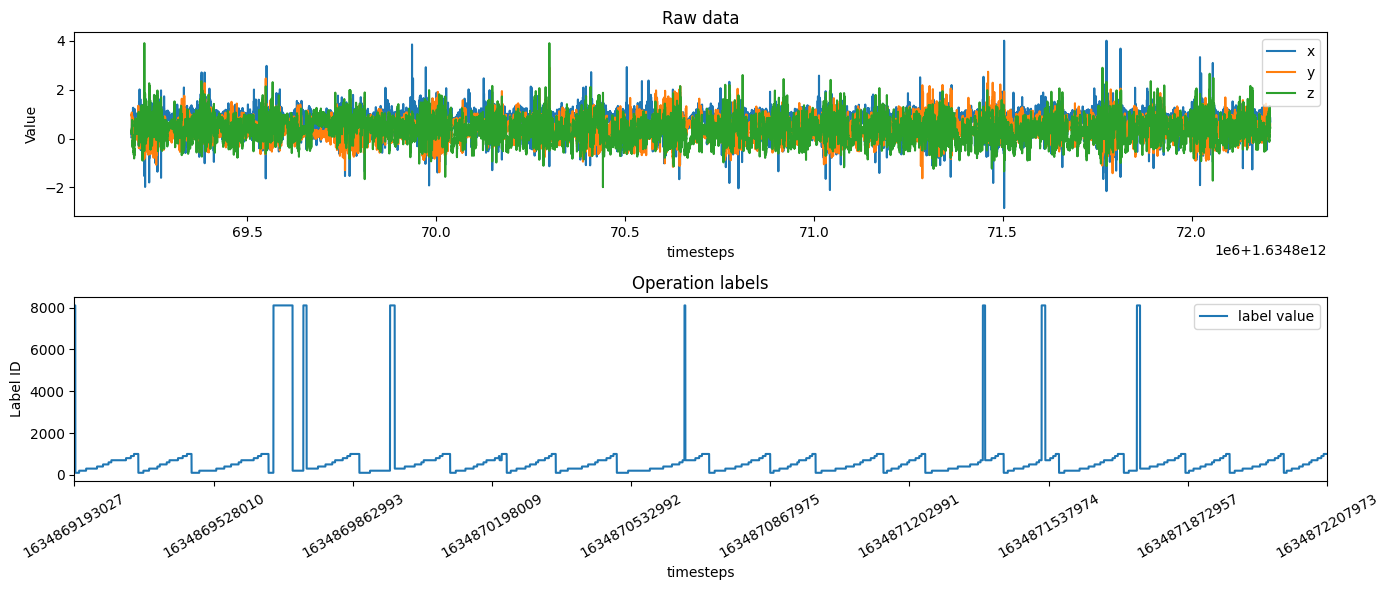

In [9]:
df = train_data_dict[train_users[0]]

n = 10  # only show n timestamps on fig
# timezone_jst = datetime.timezone(datetime.timedelta(hours=9))
# dates = [str(datetime.datetime.fromtimestamp(ts / 1000).replace(tzinfo=timezone_jst)) for ts in df['timestamp'].values]
dates = df.timestamp.values
# Select n equally spaced indices to show on the x-axis
indices = np.linspace(0, len(dates) - 1, n, dtype=int)
selected_dates = [dates[i] for i in indices]

data = df[['atr01/acc_x','atr01/acc_y','atr01/acc_z']].values

l = df['operation'].values

fig, axs = plt.subplots(2, 1, figsize=(14, 6))
# First subplot
axs[0].plot(dates, data[:,0], label='x')
axs[0].plot(dates, data[:,1], label='y')
axs[0].plot(dates, data[:,2], label='z')
axs[0].set_title('Raw data')
axs[0].set_xlabel('timesteps')
axs[0].set_ylabel('Value')
axs[0].legend()
# Set x-ticks for the current subplot
# axs[0].set_xticks(selected_dates)
# axs[0].set_xticklabels(selected_dates, rotation=60)  # Set labels and rotate
# axs[0].set_xlim([dates[0], dates[-1]])  # Set x-axis limits
# axs[0].grid()

# Second subplot
axs[1].plot(dates, l, label='label value')
axs[1].set_title('Operation labels')
axs[1].set_xlabel('timesteps')
axs[1].set_ylabel('Label ID')
axs[1].set_xticks(selected_dates)
axs[1].set_xticklabels(selected_dates, rotation=30)  # Set labels and rotate
axs[1].set_xlim([dates[0], dates[-1]])  # Set x-axis limits
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

## 2.6 Example of Virtual Data Generation

Here, we use data augmentations to generate virtual data. Participants are free to design virtual data generation algorithms.

---

## 2.6 仮想データ生成の例

ここでは、データ拡張を使用して仮想データを生成します。参加者は仮想データ生成アルゴリズムを自由に設計できます。

In [11]:
"""
This code implements a list of transforms for tri-axial raw-accelerometry
We assume that the input format is of size:
3 x (epoch_len * sampling_frequency)

Transformations included:
1. jitter
2. Channel shuffling: which axis is being switched
3. Horizontal flip: binary
4. Permutation: binary

This script is mostly based off from
https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.py
"""

def switch_axis(sample, choice):
    """
    Randomly switch the three axises for the raw files

    Args:
        sample (numpy array): 3 * FEATURE_SIZE
        choice (int): 0-6 for direction selection
    """
    x = sample[0, :]
    y = sample[1, :]
    z = sample[2, :]

    if choice == 0:
        return sample
    elif choice == 1:
        sample = np.stack([x, y, z], axis=0)
    elif choice == 2:
        sample = np.stack([x, z, y], axis=0)
    elif choice == 3:
        sample = np.stack([y, x, z], axis=0)
    elif choice == 4:
        sample = np.stack([y, z, x], axis=0)
    elif choice == 5:
        sample = np.stack([z, x, y], axis=0)
    elif choice == 6:
        sample = np.stack([z, y, x], axis=0)
    return sample


def flip(sample, choice):
    """
    Flip over the actigram on the temporal scale

    Args:
        sample (numpy array): 3 * FEATURE_SIZE
        choice (int): 0-1 binary
    """
    if choice == 1:
        sample = np.flip(sample, 1)
    return sample


def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile is True:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(
            np.random.randint(
                minSegLength, X.shape[0] - minSegLength, nPerm - 1
            )
        )
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]] : segs[idx[ii] + 1], :]
        X_new[pp : pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


def permute(sample, choice, nPerm=4, minSegLength=10):
    """
    Distort an epoch by dividing up the sample into several segments and
    then permute them

    Args:
        sample (numpy array): 3 * FEATURE_SIZE
        choice (int): 0-1 binary
    """
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = DA_Permutation(sample, nPerm=nPerm, minSegLength=minSegLength)
        sample = np.swapaxes(sample, 0, 1)
    return sample


def is_scaling_factor_invalid(scaling_factor, min_scale_sigma):
    """
    Ensure each of the abs values of the scaling
    factors are greater than the min
    """
    for i in range(len(scaling_factor)):
        if abs(scaling_factor[i] - 1) < min_scale_sigma:
            return True
    return False


def DA_Scaling(X, sigma=0.3, min_scale_sigma=0.05):
    scaling_factor = np.random.normal(
        loc=1.0, scale=sigma, size=(1, X.shape[1])
    )  # shape=(1,3)
    while is_scaling_factor_invalid(scaling_factor, min_scale_sigma):
        scaling_factor = np.random.normal(
            loc=1.0, scale=sigma, size=(1, X.shape[1])
        )
    my_noise = np.matmul(np.ones((X.shape[0], 1)), scaling_factor)
    X = X * my_noise
    return X


def scaling_uniform(X, scale_range=0.15, min_scale_diff=0.02):
    low = 1 - scale_range
    high = 1 + scale_range
    scaling_factor = np.random.uniform(
        low=low, high=high, size=(X.shape[1])
    )  # shape=(3)
    while is_scaling_factor_invalid(scaling_factor, min_scale_diff):
        scaling_factor = np.random.uniform(
            low=low, high=high, size=(X.shape[1])
        )

    for i in range(3):
        X[:, i] = X[:, i] * scaling_factor[i]

    return X


def scale(sample, choice, scale_range=0.5, min_scale_diff=0.15):
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = scaling_uniform(
            sample, scale_range=scale_range, min_scale_diff=min_scale_diff
        )
        sample = np.swapaxes(sample, 0, 1)
    return sample


def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(
        X, sigma
    )  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [
        (X.shape[0] - 1) / tt_cum[-1, 0],
        (X.shape[0] - 1) / tt_cum[-1, 1],
        (X.shape[0] - 1) / tt_cum[-1, 2],
    ]
    tt_cum[:, 0] = tt_cum[:, 0] * t_scale[0]
    tt_cum[:, 1] = tt_cum[:, 1] * t_scale[1]
    tt_cum[:, 2] = tt_cum[:, 2] * t_scale[2]
    return tt_cum


def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (
        np.ones((X.shape[1], 1))
        * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))
    ).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:, 0], yy[:, 0])
    cs_y = CubicSpline(xx[:, 1], yy[:, 1])
    cs_z = CubicSpline(xx[:, 2], yy[:, 2])
    return np.array([cs_x(x_range), cs_y(x_range), cs_z(x_range)]).transpose()


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:, 0] = np.interp(x_range, tt_new[:, 0], X[:, 0])
    X_new[:, 1] = np.interp(x_range, tt_new[:, 1], X[:, 1])
    X_new[:, 2] = np.interp(x_range, tt_new[:, 2], X[:, 2])
    return X_new


def time_warp(sample, choice, sigma=0.2):
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = DA_TimeWarp(sample, sigma=sigma)
        sample = np.swapaxes(sample, 0, 1)
    return sample

## 2.7 Figures of an example of data augmentation

---

## 2.7 データ拡張の例の図

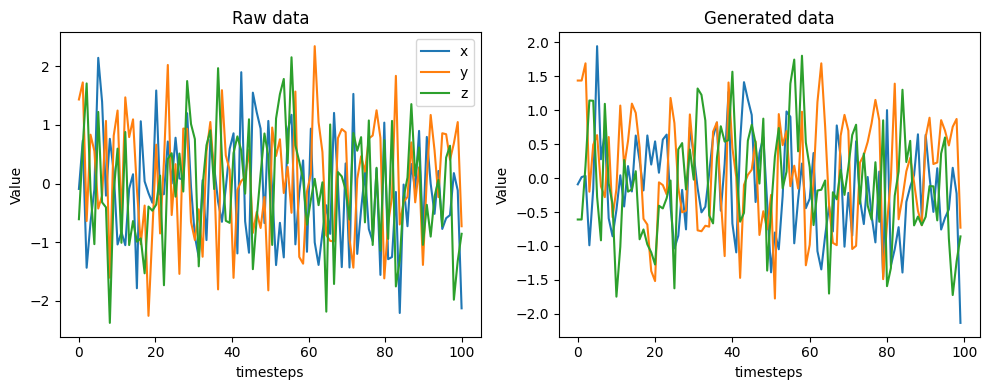

In [12]:
random_array_normal = np.random.randn(3, 100)
warped_data = time_warp(random_array_normal, 1, sigma=0.2)
x = np.linspace(0, 100, 100)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First subplot
axs[0].plot(x, random_array_normal[0,:], label='x')
axs[0].plot(x, random_array_normal[1,:], label='y')
axs[0].plot(x, random_array_normal[2,:], label='z')
axs[0].set_title('Raw data')
axs[0].set_xlabel('timesteps')
axs[0].set_ylabel('Value')
axs[0].legend()

# Second subplot
axs[1].plot(warped_data[0,:], label='x')
axs[1].plot(warped_data[1,:], label='y')
axs[1].plot(warped_data[2,:], label='z')
axs[1].set_title('Generated data')
axs[1].set_xlabel('timesteps')
axs[1].set_ylabel('Value')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

## 2.8 Implement data augmentation with training data and save them to folder

Please save the generated data as csv file in '/data/virtual/'.

---

## 2.8 トレーニング データを使用してデータ拡張を実装し、フォルダーに保存します

生成されたデータを '/data/virtual/' に csv ファイルとして保存してください。

In [13]:
def custom_virtual_data_generation_algorithm(data):
    '''
    Please modify the code and submit this function and its relative functions.
    :param data: numpy array, shape is (data length, dim=6)
    :return: numpy array, shape is (data length, dim=6)
    '''
     # Data augmentations
    left = permute(data[:,:3].transpose(), 1)
    right = time_warp(data[:,3:].transpose(), 1)

    new_data = np.concatenate([left.transpose(), right.transpose()], axis=1)
    return new_data

In [14]:
def save_virtual_data(data, filename):
  '''
  Participants can use this function to save csv data to /data/virtual/
  :param data: dataframe type, shape is (data length, dim=7), columns = new_columns = selected_columns[:6] + [selected_columns[-1]]
  :return:
  '''

  data.to_csv(os.path.join(virt_directory, filename+'.csv'), index=False)
  return

In [ ]:
def custom_virtual_data_generation(train_data_dict):
  '''
  This function aims to generate virtual and from train_data_dict, and save the data to virt_directory.
  Participants could not change the input and output of this function.
  Participants could modify the code inside this function.
  During the code submission, participants need to submit this function and its relavant functions, such as custom_virtual_data_generation_algorithm.
  '''
  for u, df in train_data_dict.items():
    print('Generating virtual data from user %s.'% u)
    # Extract sensor data and labels
    raw_data = df[selected_columns[:6]].values
    labels = df[selected_columns[-1]].values.reshape(-1,1)

    tmp = custom_virtual_data_generation_algorithm(raw_data)

    # Concatenate data with operation labels
    virtual_data = np.concatenate([tmp, labels], axis=1)

    # Convert np.array to dataframe
    df = pd.DataFrame(virtual_data, columns=new_columns)

    # Save data to /data/virtual/
    save_virtual_data(df, u)
    # df.to_csv(os.path.join(virt_directory, u+'.csv'), index=False)

custom_virtual_data_generation(train_data_dict)

Generating virtual data from user U0102.
Generating virtual data from user U0104.
Generating virtual data from user U0105.
Generating virtual data from user U0107.
Generating virtual data from user U0108.
Generating virtual data from user U0109.
Generating virtual data from user U0110.
Generating virtual data from user U0111.
Generating virtual data from user U0201.
Generating virtual data from user U0202.
Generating virtual data from user U0203.
Generating virtual data from user U0204.
Generating virtual data from user U0208.
Generating virtual data from user U0209.


In [ ]:
# Example of virtual data structure
df.head(3)

,atr01/acc_x,atr01/acc_y,atr01/acc_z,atr02/acc_x,atr02/acc_y,atr02/acc_z,operation
0,0.1475,-0.3911,-0.4669,0.406800,-0.915700,0.131900,8100.0
1,0.0638,-0.0876,-0.5153,0.406800,-0.914273,0.126878,8100.0
2,0.3535,0.1459,-0.4935,0.403266,-0.906440,0.118583,8100.0


##2.9 Check the size of virtual data

Use this code to ensure the size of virtual data is not exceeded to TBD.



---
##2.9 仮想データのサイズを確認する

このコードを使用して、仮想データのサイズが TBD を超えていないことを確認します。


In [15]:
def get_folder_size(folder_path):
    total_size = 0
    # Walk through all files and subdirectories in the folder
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            # Get the full file path
            file_path = os.path.join(dirpath, filename)
            # Add the size of each file to the total size
            total_size += os.path.getsize(file_path)
    return total_size

# Example usage
size = get_folder_size(virt_directory)
print(f"The total size of the folder is: {size} bytes")

The total size of the folder is: 89645297 bytes


# 3. Use the Generated Data to Improve HAR Model Performance



---
# 3. 生成されたデータを使用してHARモデルのパフォーマンスを向上させる


## 3.1 Read data and labels from both real and virtual folders


---
## 3.1 実フォルダと仮想フォルダの両方からデータとラベルを読み取る


In [16]:
# find csv files in 'data/virtual'
virt_paths = []
for root, dirs, files in os.walk(virt_directory):
    for file in files:
        if file.endswith('.csv'):
            virt_paths.append(os.path.join(root, file))
print('Virtual csv file paths are as shown follows:')
virt_paths

Virtual csv file paths are as shown follows:


['/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0105.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0104.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0102.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0107.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0111.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0201.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0108.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0202.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0109.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0110.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0203.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0204.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0208.csv',
 '/content/drive/MyDrive/OpenPackChallenge25/data/virtual/U0209.csv']

In [17]:
# real and virtual training data

## real data
train_data = []
for u, data in train_data_dict.items():
    train_data.append(data[new_columns].values)
    # print(data[new_columns].values.shape)

## virtual data
for p in virt_paths:
    # Load the CSV file with only the selected columns
    data = pd.read_csv(p, usecols=new_columns)
    train_data.append(data.values)

train_data = np.concatenate(train_data, axis=0)
print('Shape of train data is %s'%str(train_data.shape))

Shape of train data is (2084738, 7)


In [18]:
# validatation and test data
val_data = []
for u, data in val_data_dict.items():
    val_data.append(data[new_columns].values)

test_data = []
for u, data in test_data_dict.items():
    test_data.append(data[new_columns].values)

val_data = np.concatenate(val_data, axis=0)
test_data = np.concatenate(test_data, axis=0)

print('Shape of validation data is %s'%str(val_data.shape))
print('Shape of test data is %s'%str(test_data.shape))

Shape of validation data is (120920, 7)
Shape of test data is (325929, 7)


In [19]:
# convert operation ID to labels (from 0 to n)
labels = np.unique(train_data[:, -1])
label_dict = dict(zip(labels, np.arange(len(labels))))
train_data[:,-1] = np.array([label_dict[i] for i in train_data[:,-1]])
val_data[:,-1] =  np.array([label_dict[i] for i in val_data[:,-1]])
test_data[:,-1] =  np.array([label_dict[i] for i in test_data[:,-1]])

## 3.2 Prepare Dataloader

---

## 3.2 データローダーの準備

In [20]:
class data_loader_OpenPack(Dataset):
    def __init__(self, samples, labels, device='cpu'):
        self.samples = torch.tensor(samples).to(device)  # check data type
        self.labels = torch.tensor(labels)  # check data type

    def __getitem__(self, index):
        target = self.labels[index]
        sample = self.samples[index]
        return sample, target

    def __len__(self):
        return len(self.labels)

def sliding_window(datanp, len_sw, step):
    '''
    :param datanp: shape=(data length, dim) raw sensor data and the labels. The last column is the label column.
    :param len_sw: length of the segmented sensor data
    :param step: overlapping length of the segmented data
    :return: shape=(N, len_sw, dim) batch of sensor data segment.
    '''

    # generate batch of data by overlapping the training set
    data_batch = []
    for idx in range(0, datanp.shape[0] - len_sw - step, step):
        data_batch.append(datanp[idx: idx + len_sw, :])
    data_batch.append(datanp[-1 - len_sw: -1, :])  # last batch
    xlist = np.stack(data_batch, axis=0)  # [B, data length, dim]

    return xlist

def generate_dataloader(data, len_sw, step, if_shuffle=True):
    tmp_b = sliding_window(data, len_sw, step)
    data_b = tmp_b[:, :, :-1]
    label_b = tmp_b[:, :, -1]
    data_set_r = data_loader_OpenPack(data_b, label_b, device=device)
    data_loader = DataLoader(data_set_r, batch_size=batch_size,
                              shuffle=if_shuffle, drop_last=False)
    return data_loader

In [23]:
len_sw = 300
step = 150
batch_size = 512

train_loader = generate_dataloader(train_data, len_sw, step, if_shuffle=True)
val_loader = generate_dataloader(val_data, len_sw, step, if_shuffle=False)
test_loader = generate_dataloader(test_data, len_sw, step, if_shuffle=False)

## 3.3 Prepare Model

Reference:
https://github.com/Tian0426/CL-HAR

---
## 3.3 モデルの準備

参照:
https://github.com/Tian0426/CL-HAR


In [24]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.5):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value=True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        self.attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', self.attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class Transformer_block(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                (PreNorm(dim, Attention(dim, heads=heads, dropout=dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

class Seq_Transformer(nn.Module):
    def __init__(self, n_channel, len_sw, n_classes, dim=128, depth=4, heads=4, mlp_dim=64, dropout=0.1):
        super().__init__()
        self.patch_to_embedding = nn.Linear(n_channel, dim)
        self.c_token = nn.Parameter(torch.randn(1, 1, dim))
        self.position = PositionalEncoding(d_model=dim, max_len=len_sw)
        self.transformer = Transformer_block(dim, depth, heads, mlp_dim, dropout)
        self.to_c_token = nn.Identity()
        self.classifier = nn.Linear(dim, n_classes)


    def forward(self, forward_seq):
        x = self.patch_to_embedding(forward_seq)
        x = self.position(x)
        b, n, _ = x.shape
        c_tokens = repeat(self.c_token, '() n d -> b n d', b=b)
        x = torch.cat((c_tokens, x), dim=1)
        x = self.transformer(x)
        c_t = self.to_c_token(x[:, 0])
        return c_t

class Transformer(nn.Module):
    def __init__(self, n_channels=6, len_sw=300, n_classes=11, dim=128, depth=4, heads=4, mlp_dim=64, dropout=0.3):
        super(Transformer, self).__init__()

        self.out_dim = dim
        self.transformer = Seq_Transformer(n_channel=n_channels, len_sw=len_sw, n_classes=n_classes, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim, dropout=dropout)
        self.classifier = nn.Linear(dim, n_classes)

    def forward(self, x):
        x = self.transformer(x)
        out = self.classifier(x)
        return out
        # return out, x

In [25]:
model = Transformer()
model = model.to(device)
print(model)

Transformer(
  (transformer): Seq_Transformer(
    (patch_to_embedding): Linear(in_features=6, out_features=128, bias=True)
    (position): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer_block(
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=128, out_features=384, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
          )
          (1): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=128, out_features=64, bias=True)
           

## 3.4 Training and test

Reference:
https://github.com/jhhuang96/ConvLSTM-PyTorch/blob/master/main.py

---
## 3.4 トレーニングとテスト

参考:
https://github.com/jhhuang96/ConvLSTM-PyTorch/blob/master/main.py


In [26]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered")
                return True
        return False
early_stopping = EarlyStopping()

In [27]:
def vote_labels(label):
    # Iterate over each sample in the batch
    votel = []
    for i in range(label.size(0)):
        # Get unique labels and their counts
        unique_labels, counts = label[i].unique(return_counts=True)

        # Find the index of the maximum count
        max_count_index = counts.argmax()

        # Get the label corresponding to that maximum count
        mode_label = unique_labels[max_count_index]

        # Append the mode to the result list
        votel.append(mode_label)

    # Convert the result list to a tensor and reshape to (batch, 1)
    vote_label = torch.tensor(votel, dtype=torch.long).view(-1)
    return vote_label

In [28]:
num_epochs = 100

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

learning_rate = 0.001
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, amsgrad=True
)
optimizer = optim.Adam(
            model.parameters(), lr=learning_rate, amsgrad=True
        )
# lambda1 = lambda epoch: 1.0**epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                              factor=0.5,
                              patience=4,
                              verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_losses, val_losses = [], []
for epoch in tqdm(range(num_epochs)):
    train_loss, val_loss = [], []
    ###################
    # train the model #
    ###################
    model.train()
    true_labels, pred_labels = [], []
    for i, (sample, label) in enumerate(train_loader):
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.long)
        vote_label = vote_labels(label)
        vote_label = vote_label.to(device)
        output = model(sample)  # x_encoded.shape=batch512,outchannel128,len13
        loss = criterion(output, vote_label)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        true_labels.append(vote_label.detach().cpu().numpy())
        pred_labels.append(output.detach().cpu().numpy())

    train_losses.append(np.average(train_loss))
    # Calculate F1 scores
    y_true = np.concatenate(true_labels, axis=0)
    y_prob = np.concatenate(pred_labels, axis=0)

    # Get the predicted class labels (argmax along the class dimension)
    y_pred = np.argmax(y_prob, axis=1)  # output Shape: (batch_size, time_steps)

    # Calculate F1 score (macro F1 score)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'F1 Score of training set: {f1:.4f}')

    ######################
    # validate the model #
    ######################
    with torch.no_grad():
        model.eval()
        true_labels, pred_labels = [], []
        for i, (sample, label) in enumerate(val_loader):
            sample = sample.to(device=device, dtype=torch.float)
            label = label.to(device=device, dtype=torch.long)
            vote_label = vote_labels(label)
            vote_label = vote_label.to(device)
            output = model(sample)
            loss = criterion(output, vote_label)
            val_loss.append(loss.item())
            true_labels.append(vote_label.detach().cpu().numpy())
            pred_labels.append(output.detach().cpu().numpy())
        val_losses.append(np.average(val_loss))

        # Calculate F1 scores
        y_true = np.concatenate(true_labels, axis=0)
        y_prob = np.concatenate(pred_labels, axis=0)

        # Get the predicted class labels (argmax along the class dimension)
        y_pred = np.argmax(y_prob, axis=1)  # output Shape: (batch_size, time_steps)

        # Calculate F1 score (macro F1 score)
        f1 = f1_score(y_true, y_pred, average='macro')

        print(f'F1 Score of validation set: {f1:.4f}')

        # Check early stopping
        if early_stopping(np.average(val_losses)):
            print("Stopping at epoch %s." % str(epoch))
            break
    scheduler.step(np.average(val_loss))
    # Print the current learning rate
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
    print(f'Epoch {epoch + 1}, Learning Rate: {current_lr}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(val_losses, label='valid loss')
plt.plot(train_losses, label='train loss')
plt.grid()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    true_labels, pred_labels = [], []
    for i, (sample, label) in enumerate(test_loader):
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.long)
        vote_label = vote_labels(label)
        # vote_label = vote_label.to(device)
        output = model(sample)  # x_encoded.shape=batch512,outchannel128,len13

        true_labels.append(vote_label.numpy())
        pred_labels.append(output.detach().cpu().numpy())

    # Calculate F1 scores
    y_true = np.concatenate(true_labels, axis=0)
    y_prob = np.concatenate(pred_labels, axis=0)

    # Get the predicted class labels (argmax along the class dimension)
    y_pred = np.argmax(y_prob, axis=1)  # output Shape: (batch_size, time_steps)

    # Calculate F1 score (macro F1 score)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'F1 Score of test set: {f1:.4f}')

# 4. Submission

Participants only need to submit the code related to the virtual data generation.
During the evaluation of the challenge, we will call "custom_virtual_data_generation" function to generate virtual data. So, please ensure that all relevant codes are included in the .py file.



---
# 4. 提出

参加者は仮想データ生成に関連するコードのみを提出する必要があります。
チャレンジの評価中に、仮想データを生成するために「custom_virtual_data_generation」関数を呼び出します。したがって、関連するすべてのコードが .py ファイルに含まれていることを確認してください。


In [ ]:
# Define the functions you want to save
functions_code = """
import numpy as np

def switch_axis(sample, choice):

    x = sample[0, :]
    y = sample[1, :]
    z = sample[2, :]

    if choice == 0:
        return sample
    elif choice == 1:
        sample = np.stack([x, y, z], axis=0)
    elif choice == 2:
        sample = np.stack([x, z, y], axis=0)
    elif choice == 3:
        sample = np.stack([y, x, z], axis=0)
    elif choice == 4:
        sample = np.stack([y, z, x], axis=0)
    elif choice == 5:
        sample = np.stack([z, x, y], axis=0)
    elif choice == 6:
        sample = np.stack([z, y, x], axis=0)
    return sample


def flip(sample, choice):

    if choice == 1:
        sample = np.flip(sample, 1)
    return sample


def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile is True:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(
            np.random.randint(
                minSegLength, X.shape[0] - minSegLength, nPerm - 1
            )
        )
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]] : segs[idx[ii] + 1], :]
        X_new[pp : pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


def permute(sample, choice, nPerm=4, minSegLength=10):

    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = DA_Permutation(sample, nPerm=nPerm, minSegLength=minSegLength)
        sample = np.swapaxes(sample, 0, 1)
    return sample


def is_scaling_factor_invalid(scaling_factor, min_scale_sigma):

    for i in range(len(scaling_factor)):
        if abs(scaling_factor[i] - 1) < min_scale_sigma:
            return True
    return False


def DA_Scaling(X, sigma=0.3, min_scale_sigma=0.05):
    scaling_factor = np.random.normal(
        loc=1.0, scale=sigma, size=(1, X.shape[1])
    )  # shape=(1,3)
    while is_scaling_factor_invalid(scaling_factor, min_scale_sigma):
        scaling_factor = np.random.normal(
            loc=1.0, scale=sigma, size=(1, X.shape[1])
        )
    my_noise = np.matmul(np.ones((X.shape[0], 1)), scaling_factor)
    X = X * my_noise
    return X


def scaling_uniform(X, scale_range=0.15, min_scale_diff=0.02):
    low = 1 - scale_range
    high = 1 + scale_range
    scaling_factor = np.random.uniform(
        low=low, high=high, size=(X.shape[1])
    )  # shape=(3)
    while is_scaling_factor_invalid(scaling_factor, min_scale_diff):
        scaling_factor = np.random.uniform(
            low=low, high=high, size=(X.shape[1])
        )

    for i in range(3):
        X[:, i] = X[:, i] * scaling_factor[i]

    return X


def scale(sample, choice, scale_range=0.5, min_scale_diff=0.15):
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = scaling_uniform(
            sample, scale_range=scale_range, min_scale_diff=min_scale_diff
        )
        sample = np.swapaxes(sample, 0, 1)
    return sample


def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(
        X, sigma
    )  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [
        (X.shape[0] - 1) / tt_cum[-1, 0],
        (X.shape[0] - 1) / tt_cum[-1, 1],
        (X.shape[0] - 1) / tt_cum[-1, 2],
    ]
    tt_cum[:, 0] = tt_cum[:, 0] * t_scale[0]
    tt_cum[:, 1] = tt_cum[:, 1] * t_scale[1]
    tt_cum[:, 2] = tt_cum[:, 2] * t_scale[2]
    return tt_cum


def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (
        np.ones((X.shape[1], 1))
        * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))
    ).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:, 0], yy[:, 0])
    cs_y = CubicSpline(xx[:, 1], yy[:, 1])
    cs_z = CubicSpline(xx[:, 2], yy[:, 2])
    return np.array([cs_x(x_range), cs_y(x_range), cs_z(x_range)]).transpose()


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:, 0] = np.interp(x_range, tt_new[:, 0], X[:, 0])
    X_new[:, 1] = np.interp(x_range, tt_new[:, 1], X[:, 1])
    X_new[:, 2] = np.interp(x_range, tt_new[:, 2], X[:, 2])
    return X_new


def time_warp(sample, choice, sigma=0.2):
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = DA_TimeWarp(sample, sigma=sigma)
        sample = np.swapaxes(sample, 0, 1)
    return sample

def custom_virtual_data_generation_algorithm(data):

     # Data augmentations
    left = permute(data[:,:3].transpose(), 1)
    right = time_warp(data[:,3:].transpose(), 1)

    new_data = np.concatenate([left.transpose(), right.transpose()], axis=1)
    return new_data

def save_virtual_data(data, filename):

  data.to_csv(os.path.join(virt_directory, filename+'.csv'), index=False)
  return

def custom_virtual_data_generation(train_data_dict):

  for u, df in train_data_dict.items():
    print('Generating virtual data from user %s.'% u)
    # Extract sensor data and labels
    raw_data = df[selected_columns[:6]].values
    labels = df[selected_columns[-1]].values.reshape(-1,1)

    tmp = custom_virtual_data_generation_algorithm(raw_data)

    # Concatenate data with operation labels
    virtual_data = np.concatenate([tmp, labels], axis=1)

    # Convert np.array to dataframe
    df = pd.DataFrame(virtual_data, columns=new_columns)

    # Save data to /data/virtual/
    save_virtual_data(df, u)
    # df.to_csv(os.path.join(virt_directory, u+'.csv'), index=False)

"""

# Create a new Python file and write the functions to it
with open(rootdir+'/custom_functions.py', 'w') as file:
    file.write(functions_code)